In [250]:
import glob
import librosa
import numpy as np
import os
import torch

from hparam import hparam as hp
from speech_embedder_net import SpeechEmbedder
from VAD_segments import VAD_chunk
import scipy.stats as stats
from dvector_create import concat_segs,get_STFTs, align_embeddings
from dvector_vis import visualization
import pandas
from tqdm import tqdm
import shutil

In [251]:
### Initialization
embedder_net = SpeechEmbedder()
embedder_net.load_state_dict(torch.load('../ckpt/600_person_20_uter_epoch_120.pth'))
embedder_net.eval()
train_sequence = []
train_cluster_id = []
df = pandas.read_csv("/Users/junhengwang/coop/court_data/00085.csv", delimiter=',')
mp3_file = '/Users/junhengwang/coop/court_data/85.mp3'
tmp_dir = './tmp/'
shutil.rmtree(tmp_dir)
os.makedirs(tmp_dir, exist_ok=True)

In [252]:
### Generate ffmpeg commands
ffm_command_path = tmp_dir + 'ffm_court.txt'
ffm_file = open(ffm_command_path,'w')
for index, row in df.iterrows():
    start = float(row['start_time'])
    duration = float(row['stop_time']) - start 
    if duration < 1: continue # skip it if it is too short
    audio_file = tmp_dir + str(index) + '.wav'
    bashCommand = "ffmpeg -ss " + str(round(start,2)) + " -t " + str(round(duration,2)) + " -i " + mp3_file + ' -y -ar 16000 ' +  audio_file
    ffm_file.write(bashCommand + '\n')
ffm_file.close()

In [253]:
### Run ffmpeg
import subprocess
bashCommand = "parallel -j 50 :::: " + ffm_command_path
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
print(output)
print(error)

b''
None


In [254]:
### Create dvector for each audio
audio_files = sorted(glob.glob(tmp_dir + '*.wav'), key=lambda x:int(os.path.basename(x)[:-4]))
vis_file = open(tmp_dir + "visualization.csv","a+")
for audio_file in tqdm(audio_files):
    speaker_name = df.iloc[int(os.path.basename(audio_file)[:-4])]['speaker']
    try:
        times, segs = VAD_chunk(2, audio_file)
    except:
        print(audio_file + ' is broken')
        continue
    if segs == []:
        print('No voice activity detected in ' + audio_file)
        continue
    concat_seg = concat_segs(times, segs)
    STFT_frames = get_STFTs(concat_seg)
    if not STFT_frames: 
        print('No STFT frames extracted in ' + audio_file)
        continue
    STFT_frames = np.stack(STFT_frames, axis=2)
    STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
    embeddings = embedder_net(STFT_frames)
    aligned_embeddings = align_embeddings(embeddings.detach().numpy())
    train_sequence.append(aligned_embeddings)
    for embedding in aligned_embeddings:
        train_cluster_id.append(speaker_name)
    ### save npz for visulization, may need to clean csv first
    for index, emb in enumerate(aligned_embeddings):
        save_path = tmp_dir + str(speaker_name) + str(index) + '.npz'
        save_sequence = np.array([emb])
        save_id = np.array([speaker_name] * len(aligned_embeddings))
        np.savez(save_path, train_sequence=save_sequence, train_cluster_id=np.array([speaker_name]))
        vis_file.write(save_path + '\n')
vis_file.close()


 24%|██▎       | 174/735 [02:31<11:12,  1.20s/it]

No voice activity detected in ./tmp/190.wav


 32%|███▏      | 238/735 [03:12<03:19,  2.49it/s]

No voice activity detected in ./tmp/262.wav


 74%|███████▍  | 543/735 [05:54<01:13,  2.61it/s]

No voice activity detected in ./tmp/630.wav


 95%|█████████▌| 699/735 [07:57<00:11,  3.07it/s]

No voice activity detected in ./tmp/807.wav


 96%|█████████▌| 703/735 [07:59<00:11,  2.73it/s]

No voice activity detected in ./tmp/812.wav


100%|██████████| 735/735 [08:13<00:00,  2.26it/s]


In [255]:
### Saving dvectors
train_sequence = np.concatenate(train_sequence,axis=0)
train_cluster_id = np.asarray(train_cluster_id)
np.save('court_test_sequence',train_sequence)
np.save('court_test_cluster_id',train_cluster_id)
print(train_sequence.shape)
print(train_cluster_id.shape)

(12178, 256)
(12178,)


In [256]:
print("Speakers:")
print(set(train_cluster_id))

Speakers:
{'Stanley Reed', 'Tom C. Clark', 'Mark F. Hughes', 'Sherman Minton', 'Earl Warren', 'Bessie Margolin', 'Felix Frankfurter', 'Milton C. Denbo', 'William O. Douglas', 'nan'}


In [ ]:
### Spectral Clustering
from spectralcluster import SpectralClusterer
import numpy as np
import uisrnn

test_sequences = np.load('court_test_sequence.npy')
test_cluster_ids = np.load('court_test_cluster_id.npy')
test_size = 2000
test_sequences = np.array([np.array(test_sequences[i:i + test_size]) for i in range(0, len(test_sequences), test_size)])
test_cluster_ids = [list(test_cluster_ids[i:i + test_size]) for i in range(0,len(test_cluster_ids),test_size)]
index = 1
for sequence, cluster_ids in zip(test_sequences, test_cluster_ids):
    print("#" + str(index) + " testing:")
    print("Num of true labels:" + str(len(set(cluster_ids))))
    clusterer = SpectralClusterer(min_clusters=2,max_clusters=100,p_percentile=0.96,gaussian_blur_sigma=2)
    labels = clusterer.predict(sequence)
    print("Num of predicted labels:" + str(len(set(labels))))
    print("Accuracy:" + str(uisrnn.compute_sequence_match_accuracy(list(cluster_ids), list(labels))))
    index += 1


#1 testing:
Num of true labels:6
Num of predicted labels:2
Accuracy:0.9605
#2 testing:
Num of true labels:6
Num of predicted labels:2
Accuracy:0.6915
#3 testing:
Num of true labels:6
Num of predicted labels:2
Accuracy:0.8845
#4 testing:
Num of true labels:5
Num of predicted labels:2
Accuracy:0.911
#5 testing:
Num of true labels:6
Num of predicted labels:2
Accuracy:0.727
#6 testing:
Num of true labels:9
Num of predicted labels:2
Accuracy:0.658
#7 testing:
Num of true labels:4
Num of predicted labels:2
Accuracy:0.6235955056179775


In [ ]:
visualization(tmp_dir + 'visualization.csv', 7000)

  1%|          | 70/7000 [00:00<00:09, 696.48it/s]

./tmp/visualization.csv


100%|██████████| 7000/7000 [00:07<00:00, 913.21it/s] 


==> Finish loading
==> Finish pca
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.084s...
[t-SNE] Computed neighbors for 7000 samples in 4.631s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.000000


In [246]:
import IPython.display as ipd
ipd.Audio(mp3_file) # load a local WAV file

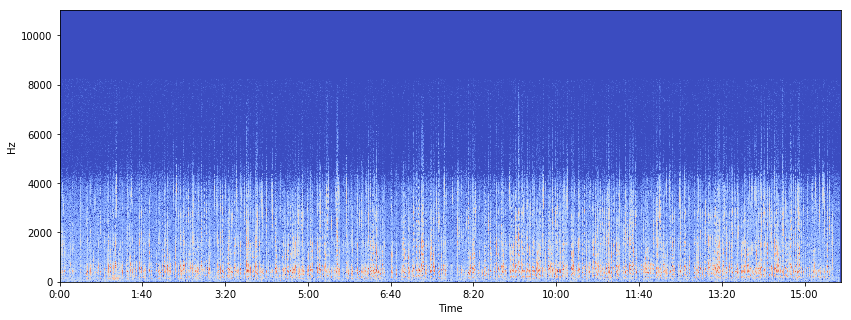

In [248]:
from scipy.io import wavfile as wav
rate, data = wav.read(mp3_file[:-4] + '.wav')
%matplotlib inline
plt.plot(data)
plt.show()